In [22]:
# Own Libraries
from utils.data import load_data
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.similarity import Similarity
# 3rd Party Libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [23]:
# Load Data
db, db_files = load_data("./data/BBDD/",".jpg")
qsd2_w1, qsd2_w1_files = load_data("./data/qsd2_w1/",".jpg")

./data/BBDD/ read: 287 images
./data/qsd2_w1/ read: 30 images


In [24]:
def image_to_windows(image: np.ndarray, n_rows: int, n_cols: int) -> np.ndarray:
    x, y = image.shape[0]/n_rows, image.shape[1]/n_cols
    x, y = int(x), int(y)
    windows = []
    for i in range(n_rows):
       for j in range(n_cols):
           windows.append(image[i*x:(i+1)*x, j*y:(j+1)*y])
    
    return windows

In [33]:
def plot_image_and_windows(images: np.ndarray, n_cols: int, n_rows: int) -> None:
    for im in images:
        windows = image_to_windows(im, n_cols=n_cols, n_rows=n_rows)
        f, axarr = plt.subplots(4,4, figsize=(10,10))
        for i in range(n_rows):
            for j in range(n_cols):
                axarr[i,j].imshow(windows[j+i*n_rows])

        plt.show()

        plt.imshow(im)
        plt.show()


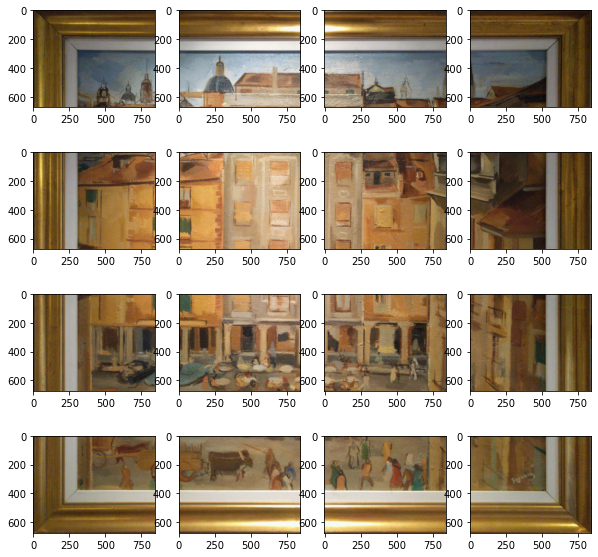

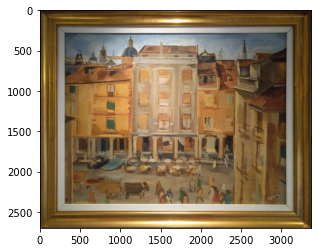

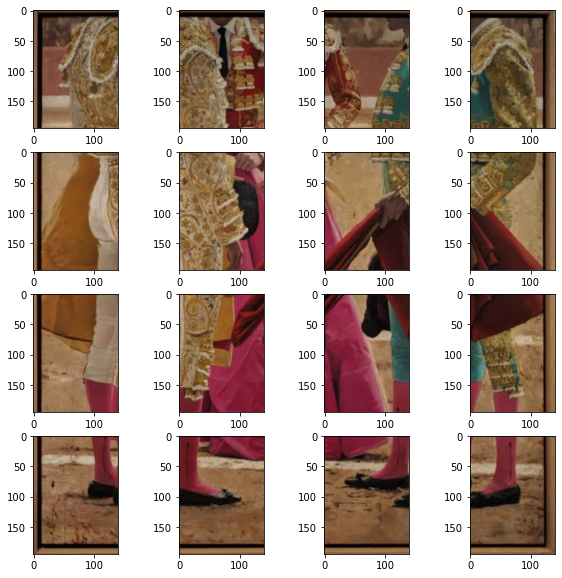

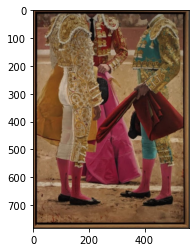

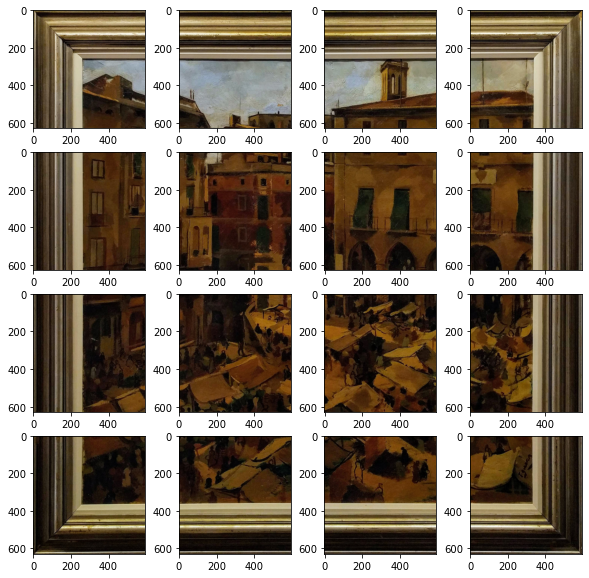

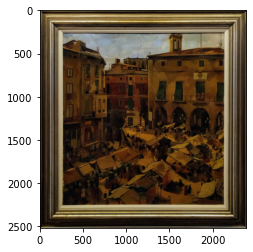

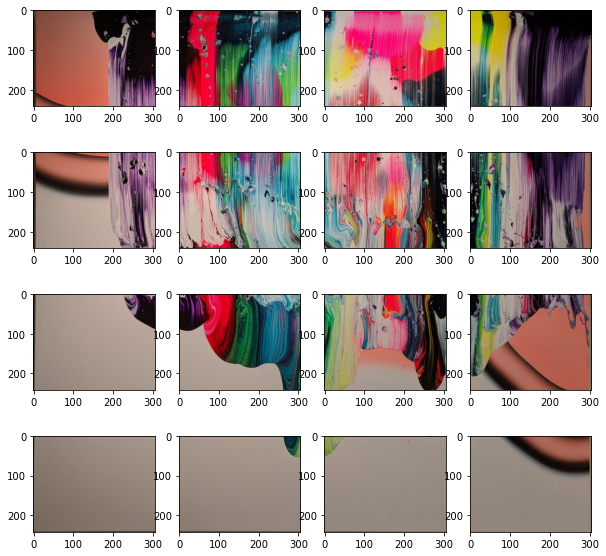

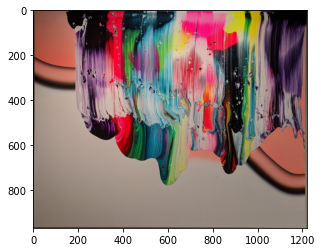

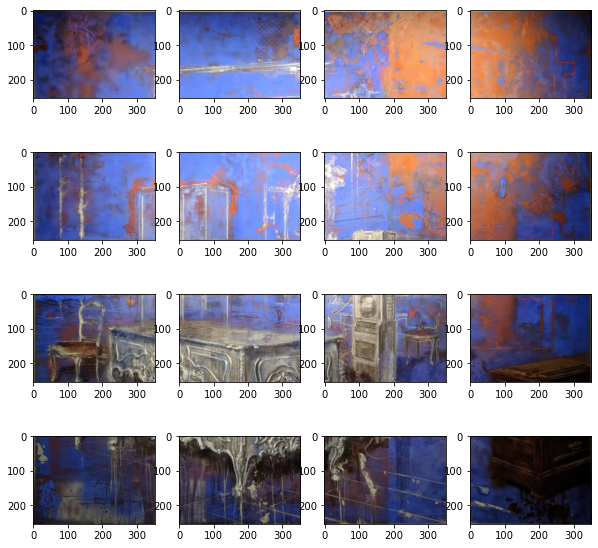

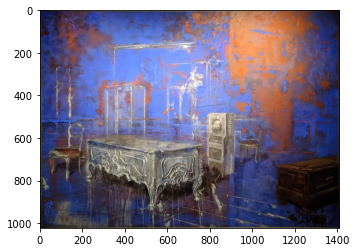

In [37]:
plot_image_and_windows(db[:5], 4, 4)